data set: https://www.kaggle.com/datasets/infamouscoder/dataset-netflix-shows

In [31]:
import findspark
findspark.init()
import pandas as pd 
import matplotlib.pyplot as plt

In [1]:
from pyspark.sql import SparkSession

#Create SparkSession
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()
data_row = spark.read.options(header='true').csv("Desktop/netflix_titles.csv")
data = data_row.toDF('show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description').cache()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/15 00:45:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:

# data.createOrReplaceTempView('data')
# spark.sql('''
# select date_added
# from data''').show()
data.createOrReplaceTempView('data')
data.printSchema()
data.count()

root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)



8807

In [66]:
#show NULL values
df_null=spark.sql("SELECT COUNT(*)-COUNT(type) As type, COUNT(*)-COUNT(title) As title, COUNT(*)-COUNT(director) As director, "
          + "COUNT(*)-COUNT(cast) As cast, COUNT(*)-COUNT(country) As country, COUNT(*)-COUNT(date_added) As date_added, "
          + "COUNT(*)-COUNT(release_year) As release_year, COUNT(*)-COUNT(rating) As rating, COUNT(*)-COUNT(duration) As duration, "
          + "COUNT(*)-COUNT(listed_in) As listed_in, COUNT(*)-COUNT(description) As description"
          +" FROM data").show()



+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|   0|    0|    2634| 825|    830|        11|           0|     4|       3|        0|          0|
+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+



In [3]:
#replace nulls with default values
data=data.fillna('not defined', subset=["director","cast", "country", "date_added", "rating", "duration"])
data.createOrReplaceTempView('data')
#check number of tv shows and movies with no director
df= spark.sql("select type, count(type) from data WHERE director == 'not defined' GROUP BY type")
df.show()

+-------+-----------+
|   type|count(type)|
+-------+-----------+
|TV Show|       2446|
|  Movie|        188|
+-------+-----------+



In [4]:
#show rows with "not defined"
df= spark.sql("select show_id, type, country, director from data WHERE director == 'not defined'")
df.show()

+-------+-------+--------------+-----------+
|show_id|   type|       country|   director|
+-------+-------+--------------+-----------+
|     s2|TV Show|  South Africa|not defined|
|     s4|TV Show|   not defined|not defined|
|     s5|TV Show|         India|not defined|
|    s11|TV Show|   not defined|not defined|
|    s15|TV Show|   not defined|not defined|
|    s16|TV Show| United States|not defined|
|    s18|TV Show|        Mexico|not defined|
|    s20|TV Show|   not defined|not defined|
|    s22|TV Show|        Turkey|not defined|
|    s26|TV Show|     Australia|not defined|
|    s32|TV Show|   not defined|not defined|
|    s33|TV Show|United Kingdom|not defined|
|    s34|TV Show|   not defined|not defined|
|    s35|TV Show|   not defined|not defined|
|    s38|TV Show|       Finland|not defined|
|    s40|TV Show|         India|not defined|
|    s41|TV Show| United States|not defined|
|    s50|TV Show|       Nigeria|not defined|
|    s51|TV Show|         India|not defined|
|    s56|T

In [5]:
#spliting and mapping genres
from pyspark.sql.functions import trim,col,explode, split
data=data.select(col('show_id'), col('type'), col('title'), col('director'), col('cast'), col('country'), col('date_added'), col('release_year'), col('rating'), col('duration'), col('description'),explode(split(col('listed_in'),","), ).alias("genre"))
genres_dict ={'Documentaries':'Documentaries',
     'British TV Shows': 'International',
     'International TV Shows':'International', 
     'Crime TV Shows':'Crime',
    'Docuseries':'Documentaries', 
     'TV Dramas':'Dramas', 
     'Children & Family Movies':'Children & Family Movies', 
     'Dramas':'Dramas',
     'Comedies':'Comedies', 
     'TV Comedies':'Comedies', 
     'Thrillers':'Thrillers',
     'TV Thrillers':'Thrillers',
     'Horror Movies':'Horror', 
     "Kids' TV":"Kids' TV", 
     'Action & Adventure':'Action & Adventure', 
     'Reality TV':'Reality TV',
     'Anime Series':'Anime', 
     'International Movies':'International', 
     'Sci-Fi & Fantasy':'Sci-Fi & Fantasy',
       'Classic Movies':'Classic', 
     'TV Shows':'TV Shows', 
     'Stand-Up Comedy':'Stand-Up Comedy & Talk Shows',
       'TV Action & Adventure':'Action & Adventure', 
     'Movies':'Movies', 
     'Korean TV Shows':'International',
     'Stand-Up Comedy & Talk Shows':'Stand-Up Comedy & Talk Shows',
       'Classic & Cult TV':'Classic', 
     'Anime Features':'Anime', 
       'Cult Movies':'Cult', 
     'Classic Movies':'Classic',
     'Independent Movies':'Independent Movies', 
     'TV Horror':'Horror',
        'Music & Musicals':'Music & Musicals', 
       'LGBTQ Movies':'LGBTQ', 
     'Sports Movies':'Sport',
          'Spanish-Language TV Shows':'International',
         'Romantic TV Shows':'Romantic',
         'Romantic Movies':'Romantic',
         'TV Action & Adventure':'Action & Adventure',
         'TV Sci-Fi & Fantasy': 'Sci-Fi & Fantasy',
     'International Movies':'International',
     'Faith & Spirituality':'Faith & Spirituality',
      'Science & Nature TV':'Science & Nature'
                     }
data_genres = data.withColumn("genre", trim(data.genre))\
                  .replace(to_replace=genres_dict, subset=['genre']).dropDuplicates(["show_id"])
data_genres.cache()
data_genres.createOrReplaceTempView('data')


In [6]:
df= spark.sql('select show_id, type, title, genre from data order by show_id').show()

+-------+-------+--------------------+--------------------+
|show_id|   type|               title|               genre|
+-------+-------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|       Documentaries|
|    s10|  Movie|        The Starling|            Comedies|
|   s100|TV Show|        On the Verge|            Comedies|
|  s1000|  Movie|            Stowaway|              Dramas|
|  s1001|  Movie|            Wild Dog|  Action & Adventure|
|  s1002|  Movie|            Oloibiri|              Dramas|
|  s1003|  Movie|        Tell Me When|            Comedies|
|  s1004|TV Show|                Zero|       International|
|  s1005|TV Show|  Izzy's Koala World|            Kids' TV|
|  s1006|  Movie|Keymon and Nani i...|Children & Family...|
|  s1007|  Movie|Motu Patlu Dino I...|Children & Family...|
|  s1008|  Movie|Motu Patlu in Oct...|Children & Family...|
|  s1009|  Movie|Motu Patlu VS Rob...|Children & Family...|
|   s101|TV Show|Tobot Galaxy Dete...|  

In [104]:
import plotly.express as px

pandasDF = spark.sql("SELECT type, COUNT(show_id) num_shows FROM data WHERE"
                     +" date_added LIKE \"%2021%\"  GROUP BY type").toPandas()
fig = px.bar(pandasDF, x='type', y='num_shows')
fig.show()


In [106]:
#most productive countries in film making
from pyspark.sql import functions as F
import plotly.express as px
import plotly.graph_objects as go 
exploded_countries=data.select(col("type"),explode(split(data.country,",")).alias("country"))\
                            .filter(col("date_added").like("%2021%"))\
                            
exploded_countries_clean=exploded_countries.withColumn("country", trim(exploded_countries.country))
count_country=exploded_countries_clean.groupBy("country").count()
chart_data=count_country.select(count_country["country"], count_country["count"].alias("num_shows"))\
                            \
                            .withColumn("country", F.when(F.col('num_shows') < 30, 'Other').otherwise(F.col('country')))\
                            .groupby('country')\
                            .agg(
                            F.sum('num_shows').alias('num_shows')
                            ).orderBy(col("num_shows").desc()).toPandas()
                            
#plot a donut chart
fig = go.Figure()
df = chart_data
fig2 = px.pie(df, values='num_shows', names='country')
fig.add_traces(fig2.data)
fig.update_traces(textposition='outside',
                  hole=.6)
fig.update_layout(width = 800, height = 600,
                  margin = dict(t=0, l=0, r=0, b=0))
fig.show()

In [108]:
import plotly.express as px
import plotly.graph_objects as go 

pandasDF = spark.sql("SELECT type, rating, COUNT(show_id) num_shows FROM data" 
                     +" WHERE date_added LIKE \"%2021%\" GROUP BY type, rating").toPandas()
fig = px.bar(pandasDF, x='rating', y='num_shows', color='type', title='Relation between Type and Rating')
fig.show()

In [112]:
#most popular genres
import plotly.express as px
import plotly.graph_objects as go 

pandasDF = spark.sql("SELECT genre,type, COUNT(show_id) num_shows FROM data" 
                     +" WHERE date_added LIKE \"%2021%\" GROUP BY genre, type"
                    +" ORDER BY num_shows DESC").toPandas()
fig = px.bar(pandasDF, x='genre', y='num_shows',color='type', title='Most popular Genres')
fig.show()

In [28]:
#top 15 most productive directors and their films 
top_directors=data_genres.select(col("director"),  col("genre"), col("country"))\
            .filter((col("director")!="not defined")&(col("date_added").like("%2021%"))&((col("genre")=="Dramas")|(col("genre")=="Comedies")))\
            .groupBy("country","director","genre")\
            .count().orderBy(col("count").desc()).limit(15)
top_directors.show()

+-------------+--------------------+--------+-----+
|      country|            director|   genre|count|
+-------------+--------------------+--------+-----+
|      Nigeria|        Kayode Kasum|Comedies|    3|
|        India|         Prakash Jha|  Dramas|    2|
|United States|         Chris Weitz|  Dramas|    2|
|       Turkey|      Kıvanç Baruönü|Comedies|    2|
|United States|        David Zucker|Comedies|    2|
|United States|          Rob Reiner|Comedies|    2|
|United States|Michael Patrick King|Comedies|    2|
|  not defined|          Tosin Igho|  Dramas|    2|
|  not defined|Delhiprasad Deena...|Comedies|    2|
|        India|       Milan Luthria|  Dramas|    2|
|       Turkey|         Hakan Algül|Comedies|    2|
|United States|     Lasse Hallström|  Dramas|    2|
|      Romania|      Cristina Jacob|Comedies|    2|
|United States|      Garry Marshall|Comedies|    2|
|United States|Paul Thomas Anderson|  Dramas|    2|
+-------------+--------------------+--------+-----+



In [27]:
import plotly.express as px
import plotly.graph_objects as go 
df=top_directors.select('country','director','genre',col('count').alias('num_films')).toPandas()
fig = px.sunburst(df, path=['country', 'genre', 'director'], values='num_films')
fig.show()

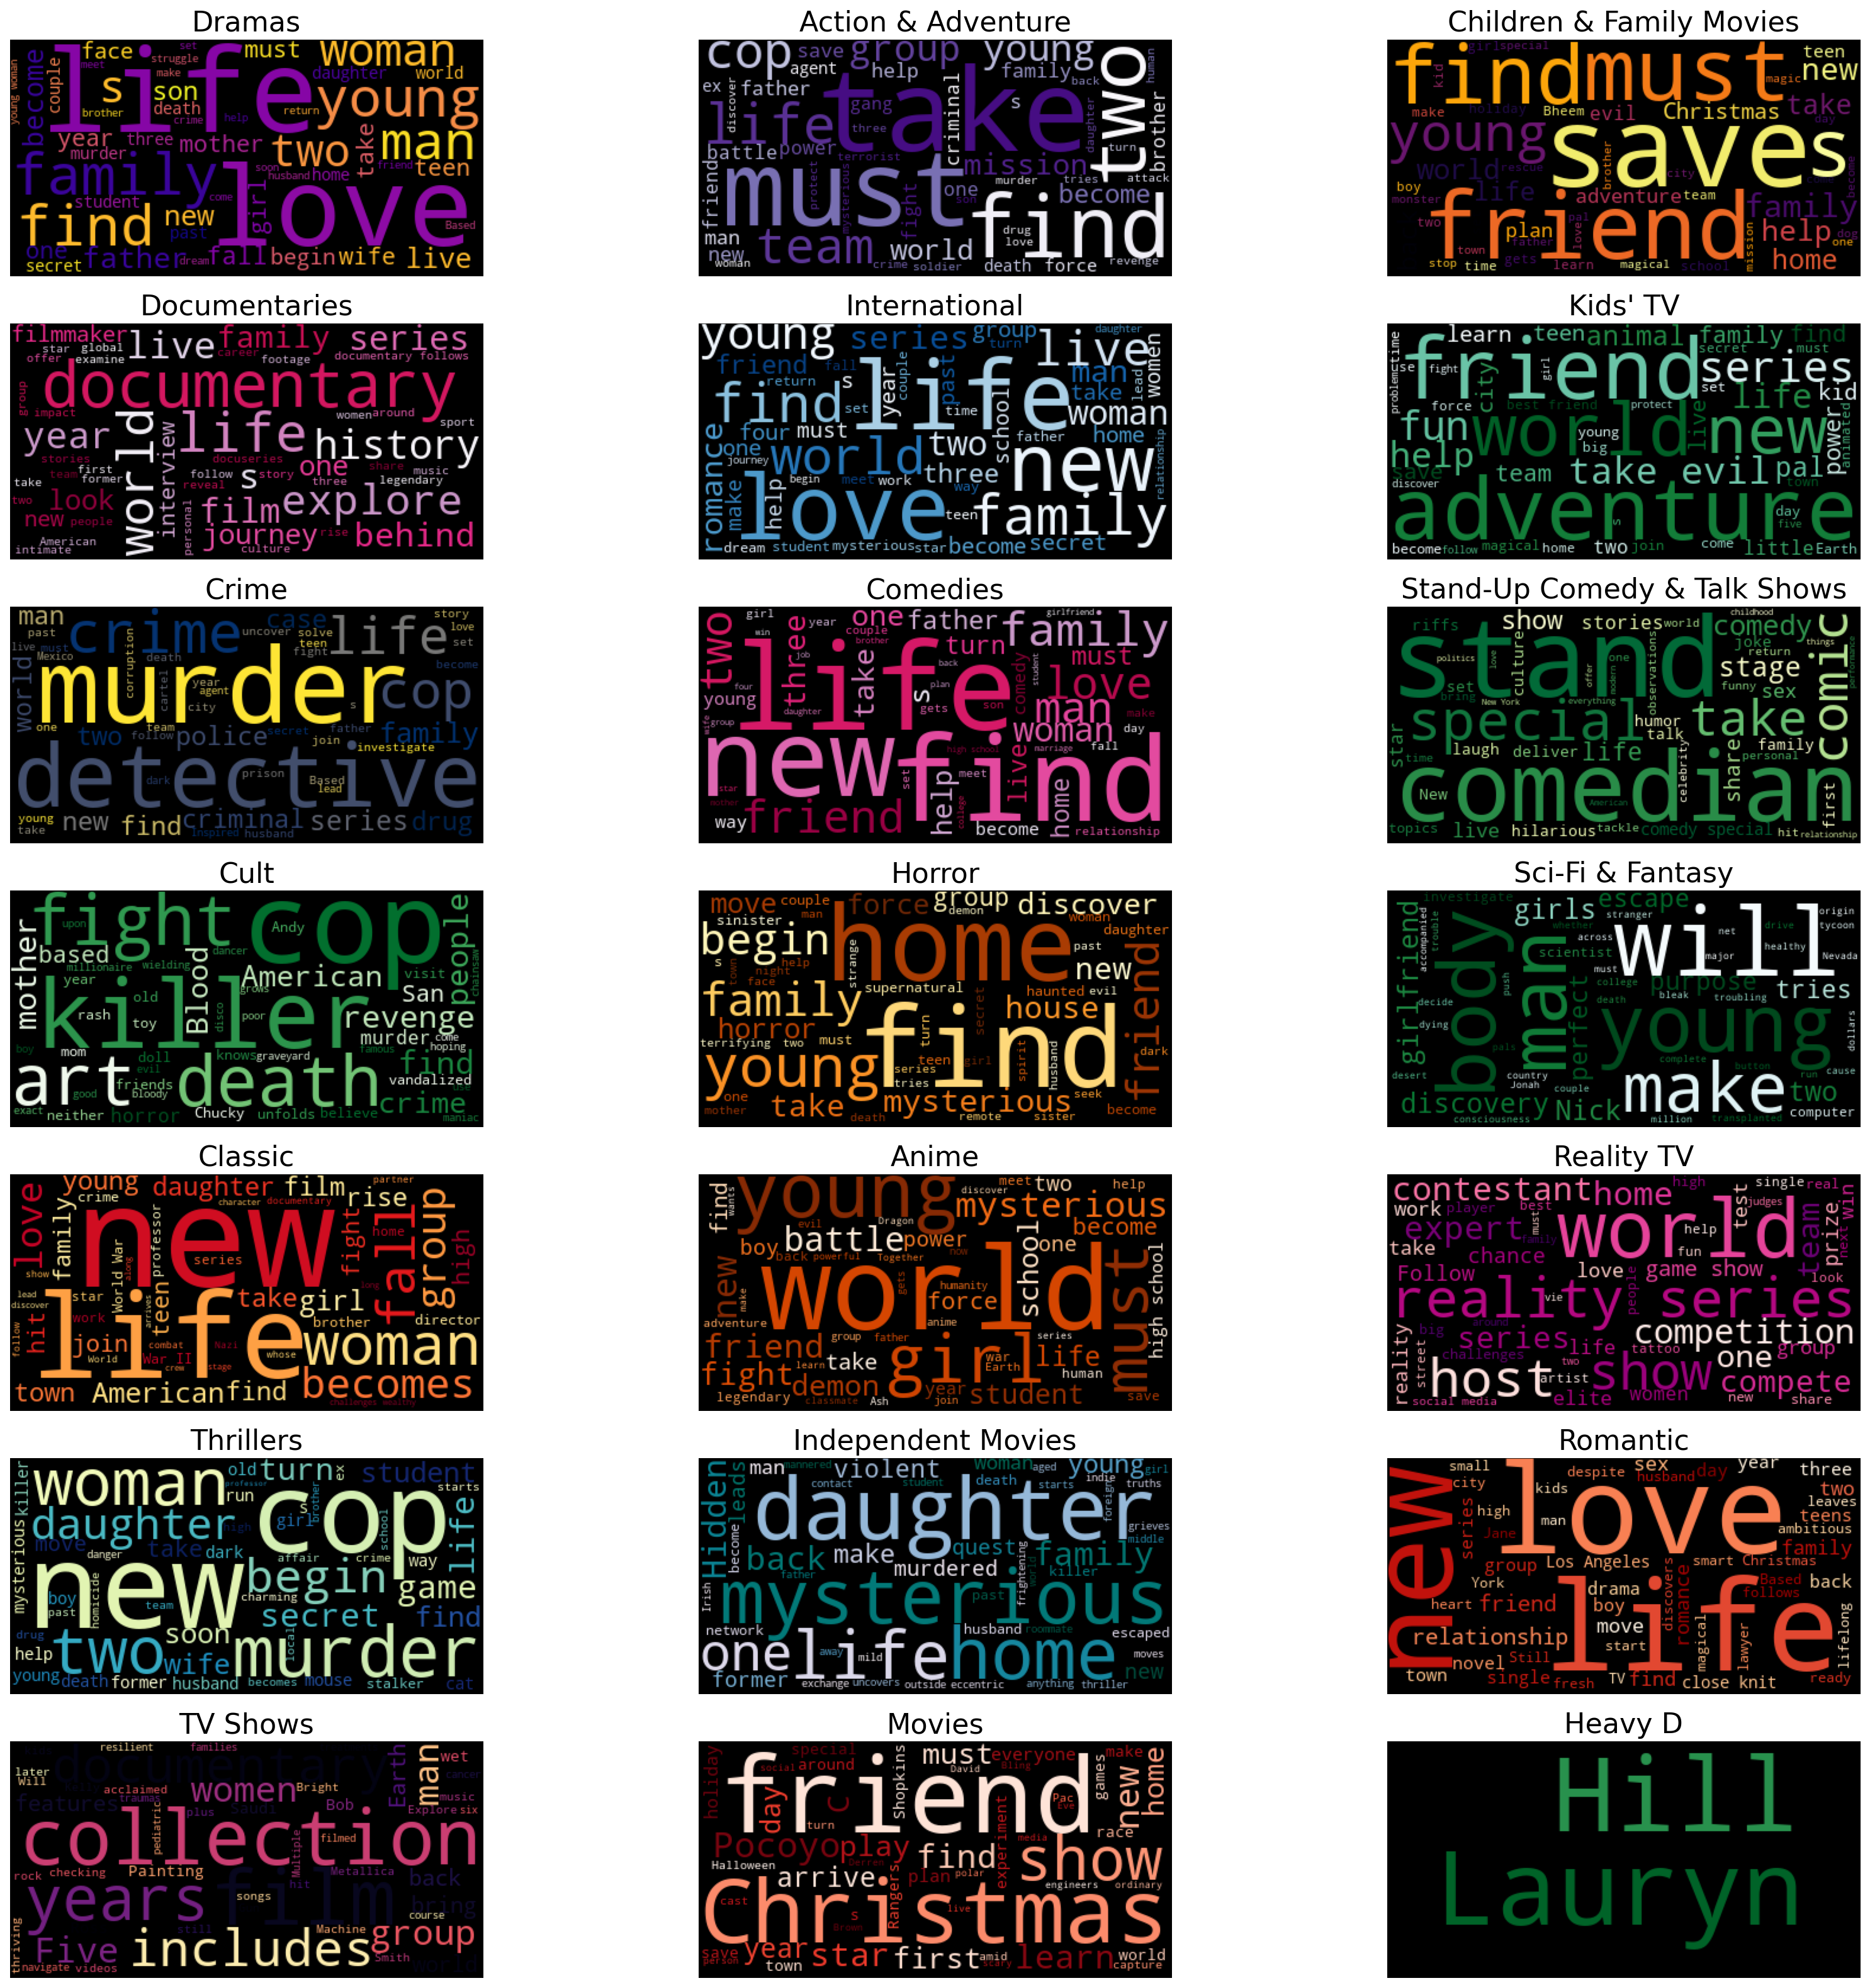

In [39]:
from wordcloud import WordCloud

df=data_genres.toPandas()
colormaps = ['plasma', 'Purples','inferno','PuRd', 'Blues', 'BuGn','cividis', 'PuRd','YlGn','Greens',
'YlOrBr', 'BuGn','YlOrRd',  'Oranges', 'RdPu',
  'YlGnBu', 'PuBuGn', 'OrRd','magma','Reds','BuGn']
plt.figure(figsize=(25, 25), dpi=160)
for i,value in enumerate(df['genre'].unique()):
        try:
            plt.subplot(7, 3, i+1)
            plt.title(value,fontsize=20)
            plt.imshow(WordCloud(colormap=colormaps[i],max_words=50).generate(text = ' '.join(df[df['genre']==value]['description'])))
            plt.axis('off')
        except ValueError:
            break
